# Inference 

In [1]:
# imports
import os, sys

# third party imports
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import os
from scipy import ndimage
from IPython import display 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
from ants import from_numpy, resample_image, registration, apply_transforms
import pydicom
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
tf.config.set_visible_devices(gpus[3], 'GPU') # using GPU3

2022-07-21 17:16:29.407880: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


# Utility functions

In [2]:
############################
# Result Analysis function #
############################

def get_2d_quiver(flow_2d, sp_factor = 20):
    """
    flow_2d: Flow filed in 2d+3 format. Example (512,512,3)
    sp_factor = sparsity factor.
    """
    spatial_flow = flow_2d[:, :, 0:2]
    meshg = meshgridnd_like(spatial_flow[::sp_factor, ::sp_factor, 0])
    mesh = np.asarray(meshg)
    mesh_mv = np.moveaxis(mesh, 0, -1)
    meshX = mesh_mv[:, :, 0]
    meshY = mesh_mv[:, :, 1]


    flowX_2d = flow_2d[::sp_factor, ::sp_factor, 0]
    flowY_2d = flow_2d[::sp_factor, ::sp_factor, 1]
    flowZ_2d = flow_2d[::sp_factor, ::sp_factor, 2]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.quiver(meshX, meshY, flowX_2d, flowY_2d, flowZ_2d )
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect('equal')
    
    return fig

def meshgridnd_like(in_img, rng_func=range):
    new_shape = list(in_img.shape)
    all_range = [rng_func(i_len) for i_len in new_shape]
    return tuple([x_arr.swapaxes(0, 1) for x_arr in np.meshgrid(*all_range)])
def norm (array):
    array = (array-array.min())/(array.max() - array.min())
    return array


#######################
## Callback function ##
#######################

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


def plot_learning_curve(log_df,
                        loss_name='loss',
                        loo_idx=None,
                        ylim=(None, None),
                        logscale=False,
                        **kwargs):
    """
    """

    # Data from the log.csv
    epochs = np.arange(log_df.epoch.iloc[0] + 1, log_df.epoch.iloc[-1] + 2, 1, dtype=np.uint32)

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=kwargs.get('fig_size', (9, 5)))

    if loo_idx is not None:
        plt.title(f'Learning Curves (Loss) (LOOCV: {loo_idx + 1})')
    else:
        plt.title(f'Learning Curves ({loss_name})')
    plt.xlabel('Epoch')  
    plt.ylabel('Loss')
    if logscale:
        plt.yscale('log')
        plt.grid(True, which='both')
    if ylim[0] is not None:
        plt.ylim(bottom=ylim[0])
    if ylim[1] is not None:
        plt.ylim(top=ylim[1])
    plt.plot(epochs, log_df[f'{loss_name}'], '-', label='Training')
    # plt.plot(epochs, log_df[f'val_{loss_name}'], '-', label='Validation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.style.use('seaborn-white')
    
def read_dicom_files(dicom_dir):
    try:
        dicom_files = glob.glob(os.path.join(dicom_dir, "*.*"))
        sorted_dicom_files = sorted(dicom_files)
        stacked_dicom = [pydicom.dcmread(dicom_file) for dicom_file in sorted_dicom_files]
        return stacked_dicom
    except IndexError as e:
        print(f"{e}, at path {dicom_dir}")
        return None

def create_3d(dicom_files):
    stacked_dicom = dicom_files  # stack of dicom files in a list

    image_shape = list(stacked_dicom[0].pixel_array.shape)
    image_shape.append(len(stacked_dicom))
    image_3d = np.zeros(image_shape)

    for j in range(len(stacked_dicom)):
        image_3d[:, :, j] = stacked_dicom[j].pixel_array

    return image_3d

def make_patches(image, patch_size= 64):
    stride = int(patch_size)

    image_patches = []
    locations = []
    for i in range(0, image.shape[0], stride):
        for j in range(0, image.shape[1], stride):
            Patch = np.zeros((patch_size,patch_size,192))
            Patch[Patch==0]= -1024/10000
            img_patch = image[i:i + patch_size,j:j + patch_size, :]
 
            Patch[: img_patch.shape[0],:img_patch.shape[1],:] = img_patch

            patch_img = Patch
            image_patches.append(patch_img)
            locations.append((i, j))

    patch_array = np.zeros((len(image_patches),patch_size,patch_size,image.shape[-1]))
    # print("len img patch", len(image_patches))
    
    for idx in range(len(image_patches)):
        patch_array[idx,:,:,:] =image_patches[idx]
    return patch_array, locations


# Build and Compile Model

In [3]:
vol_shape = (64, 64, 192)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

print(vxm_model.input)
print(vxm_model.output)

# Loss
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.01
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

2022-07-21 17:16:33.061128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 17:16:33.574495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22052 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


[<KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_source_input')>, <KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_target_input')>]
[<KerasTensor: shape=(None, 64, 64, 192, 1) dtype=float32 (created by layer 'vxm_dense_transformer')>, <KerasTensor: shape=(None, 64, 64, 192, 3) dtype=float32 (created by layer 'vxm_dense_flow')>]


# Variables and paths

In [4]:
save_model_path = f'./model_a2d' 

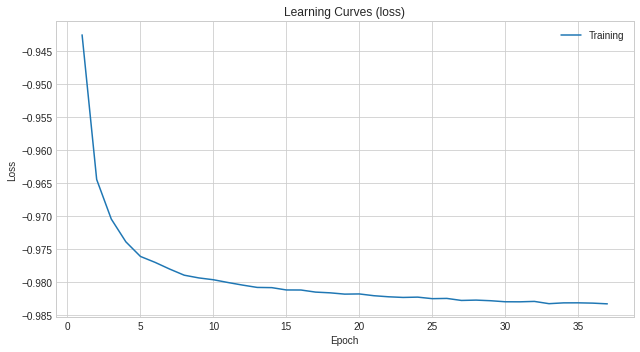

,epoch,loss,vxm_dense_flow_loss,vxm_dense_transformer_loss
36,36,-0.983333,0.154288,-0.984878


In [5]:
log_df = pd.read_csv(os.path.join(save_model_path, r'log_a2d.csv'))
plot_learning_curve(log_df)
display.display(log_df.iloc[[log_df.loss.idxmin()]])

In [6]:
best_epoch = log_df.loss.idxmin()
print(best_epoch)
vxm_model.load_weights(glob.glob(os.path.join(save_model_path, "weights_00034_-0.9832.h5"))[0])


36


# Single image path

In [7]:
V_moving = np.zeros((512,512,192))
V_fixed  = np.zeros((512,512,192))

patch_size = 64
patch_number = int((512/patch_size)*(512/patch_size))

moving_path = "/media/monib/ext1/work2022/Base_Dataset/vm_data_affine_a2d/input/val/example_A/HCC_1175_a"
fixed_path = "/media/monib/ext1/work2022/Base_Dataset/vm_data_affine_a2d/input/val/example_B/HCC_1175_d"


moving = create_3d(read_dicom_files(moving_path))/10000
fixed = create_3d(read_dicom_files(fixed_path))/10000
if moving.shape[-1] < 192:
    print("slices larger 192. change the file")
        
V_moving[...,:moving.shape[-1]] = moving
V_fixed[...,:fixed.shape[-1]] = fixed

    
        
moving_patches , location_A = make_patches(V_moving,patch_size)
fixed_patches  , location_B = make_patches(V_fixed,patch_size)
print(moving_patches.shape)


slices larger 192. change the file
(64, 64, 64, 192)


In [8]:
# moving_patches , location_A = make_patches(V_moving[val_subject_num:val_subject_num+1],patch_size)
# fixed_patches  , location_A = make_patches(V_fixed[val_subject_num:val_subject_num+1] ,patch_size)
                                                 

In [10]:
with tf.device('GPU:3'):
    val_pred = vxm_model.predict([moving_patches,fixed_patches]);
# print(val_pred.shape)

2/2 [==============================] - 1s 651ms/step


In [ ]:
# val_pred

In [11]:
recon_image = np.zeros((512,512,192))
for loc_idx in range(len(location_A)):
    a_coor_A, b_coor_A = location_A[loc_idx][0] , location_A[loc_idx][1]  
    recon_image[a_coor_A:a_coor_A+patch_size,
                b_coor_A:b_coor_A+patch_size,...]= val_pred[0][loc_idx][...,0]
    
# recon_image = np.swapaxes(recon_image[:512,:512,:],0,1)*10000
recon_image =recon_image[:512,:512,:]*10000

print(recon_image.shape)
print(recon_image.max())
print(recon_image.min())

(512, 512, 192)
2692.9286122322083
0.0


In [12]:
slice_number = 60
moving = V_moving[...,slice_number]*10000
fixed = V_fixed[...,slice_number]*10000
predict = recon_image[:,:,slice_number]

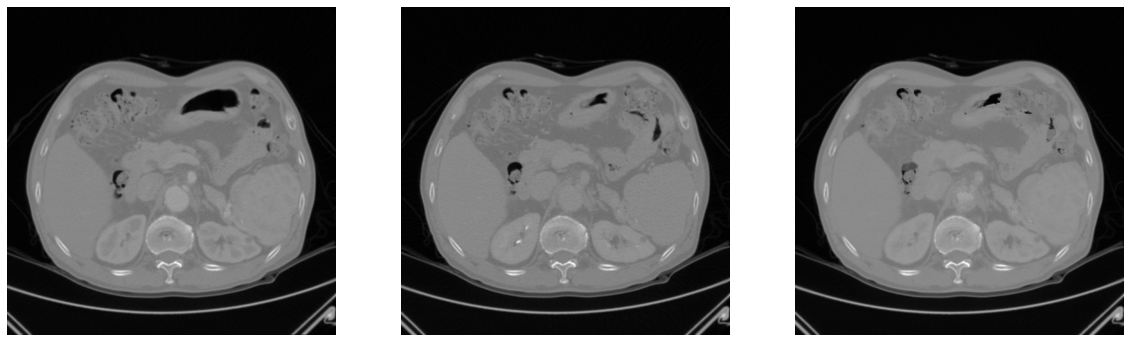

In [13]:
plt.figure(figsize= (20,40))
plt.subplot(1, 3, 1).axis('off')       
plt.imshow(moving,cmap='gray')

plt.subplot(1, 3, 2).axis('off')    
plt.imshow(fixed ,cmap='gray')
plt.subplot(1, 3, 3).axis('off')
plt.imshow(predict ,cmap='gray')
plt.show()

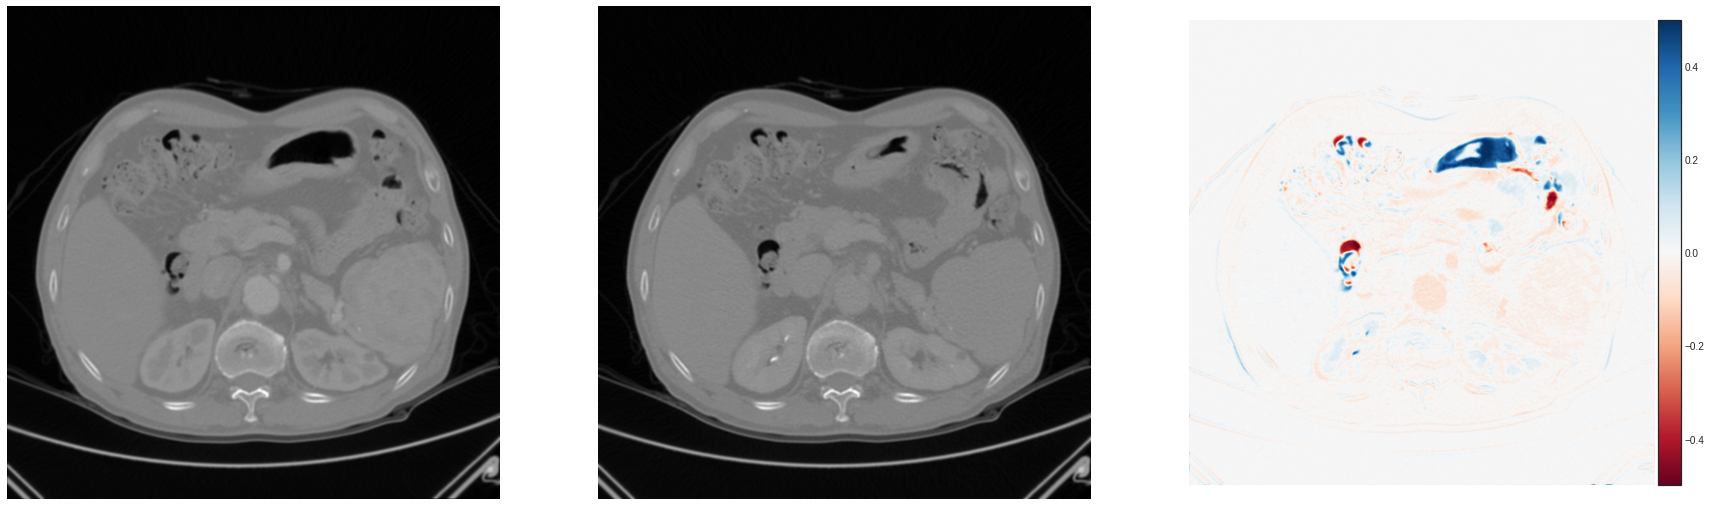

In [14]:
def norm (array):
    array = (array-array.min())/(array.max() - array.min())
    return array

from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2,ax3) =plt.subplots(1, 3,figsize=(30,30))


z1_plot = ax1.imshow(moving,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(fixed ,cmap='gray')
ax2.axis("off")

z3_plot = ax3.imshow((norm(fixed) - norm(moving)),cmap='RdBu' ,vmin =- 0.5, vmax = 0.5 )
ax3.axis("off")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(z3_plot, cax=cax)

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2,ax3) =plt.subplots(1, 3,figsize=(30,30))


z1_plot = ax1.imshow(predict,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(fixed ,cmap='gray')
ax2.axis("off")

z3_plot = ax3.imshow((norm(fixed) - norm(predict)),cmap='RdBu' ,vmin =- 0.5, vmax = 0.5 )
ax3.axis("off")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(z3_plot, cax=cax)

plt.show()

---

# 5. Prediction Data Save & Result analysis

In [ ]:
nii_input = nib.load(val_D_paths[val_subject_num])
header = nii_input.header
new_image = nib.Nifti1Image(moving_data[val_subject_num],nii_input.affine, header)
nib.save(new_image,'moving_HCC_1765_D.nii')

In [ ]:
nii_input = nib.load(val_P_paths[val_subject_num])
header = nii_input.header
new_image = nib.Nifti1Image(fixed_data[val_subject_num],nii_input.affine, header)
nib.save(new_image,'fixed_HCC_1765_P.nii')

In [ ]:
recon_image = np.zeros((512,512,192))
for loc_idx in range(len(location_A)):
    a_coor_A, b_coor_A = location_A[loc_idx][1] , location_A[loc_idx][2]  
    recon_image[a_coor_A:a_coor_A+patch_size,
                b_coor_A:b_coor_A+patch_size,...]= val_pred[0][loc_idx][...,0]
    
# recon_image = np.swapaxes(recon_image[:512,:512,:],0,1)*10000
recon_image =recon_image[:512,:512,:]*10000

print(recon_image.shape)
print(recon_image.max())
print(recon_image.min())

In [ ]:
nii_input = nib.load(val_D_paths[val_subject_num])
z_slice = nii_input.get_fdata()
header = nii_input.header
new_image = nib.Nifti1Image(recon_image,nii_input.affine, header)
nib.save(new_image,'moved_HCC_1469_D.nii')